## PyGMTSAR Co-Seismic Interferogram: Pico do Fogo Volcano Eruption on Cape Verde's Fogo Island, 2014

The PyGMTSAR InSAR library, Geomed3D Geophysical Inversion Library, N-Cube 3D/4D GIS Data Visualization, among others, are my open-source projects developed in my free time. I hold a Master's degree in STEM, specializing in radio physics. In 2004, I received the first prize in the All-Russian Physics Competition for significant results in forward and inverse modeling for nonlinear optics and holography. These skills are also applicable to modeling Gravity, Magnetic, and Thermal fields, as well as satellite interferometry processing. With 20 years of experience as a data scientist and software developer, I have contributed to scientific and industrial development, working on government contracts, university projects, and with companies like LG Corp and Google Inc.

You can support my work on [Patreon](https://www.patreon.com/pechnikov), where I share updates on my projects, publications, use cases, examples, and other useful information. For research and development services and support, please visit my profile on the freelance platform [Upwork](https://www.upwork.com).

### Resources
- Google Colab Pro notebooks and articles on [Patreon](https://www.patreon.com/pechnikov),
- Google Colab notebooks on [GitHub](https://github.com),
- Docker Images on [DockerHub](https://hub.docker.com),
- Geological Models on [YouTube](https://www.youtube.com),
- VR/AR Geological Models on [GitHub](https://github.com),
- Live updates and announcements on [LinkedIn](https://www.linkedin.com/in/alexey-pechnikov/).

© Alexey Pechnikov, 2024

$\large\color{blue}{\text{Hint: Use menu Cell} \to \text{Run All or Runtime} \to \text{Complete All or Runtime} \to \text{Run All}}$
$\large\color{blue}{\text{(depending of your localization settings) to execute the entire notebook}}$

## Load Modules to Check Environment

In [1]:
import platform, sys, os

## Google Colab Installation

### Install GMTSAR
https://github.com/gmtsar/gmtsar

In [2]:
if 'google.colab' in sys.modules:
    count = !ls /usr/local | grep GMTSAR | wc -l
    if count == ['0']:
        !export DEBIAN_FRONTEND=noninteractive
        !apt-get update > /dev/null
        !apt install -y csh autoconf gfortran \
            libtiff5-dev libhdf5-dev liblapack-dev libgmt-dev gmt-dcw gmt-gshhg gmt  > /dev/null
        # GMTSAR codes are not so good to be compiled by modern GCC
        !apt install gcc-9 > /dev/null
        !update-alternatives --install /usr/bin/gcc gcc /usr/bin/gcc-9 10
        !update-alternatives --config gcc
        !gcc --version | head -n 1
        !rm -fr /usr/local/GMTSAR
        !git config --global advice.detachedHead false
        !cd /usr/local && git clone -q --branch master https://github.com/gmtsar/gmtsar GMTSAR
        # revert recent broken commit
        !cd /usr/local/GMTSAR && git checkout e98ebc0f4164939a4780b1534bac186924d7c998 > /dev/null
        !cd /usr/local/GMTSAR && autoconf > /dev/null
        !cd /usr/local/GMTSAR && ./configure --with-orbits-dir=/tmp > /dev/null
        !cd /usr/local/GMTSAR && make 1>/dev/null 2>/dev/null
        !cd /usr/local/GMTSAR && make install >/dev/null
        # fix for missed script, use bash instead of csh interpretator
        # note: csh messes stdout and stderr in Docker environment, it's resolved in PyGMTSAR code
        !echo '#!/bin/sh' > /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !echo echo /usr/local/GMTSAR/share/gmtsar >> /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !chmod a+x /usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        !/usr/local/GMTSAR/bin/gmtsar_sharedir.csh
        # test one GMTSAR binary
        !/usr/local/GMTSAR/bin/make_s1a_tops 2>&1 | head -n 2

In [3]:
import sys
if 'google.colab' in sys.modules:
    !apt install -y xvfb > /dev/null
    !{sys.executable} -m pip install pyvista xvfbwrapper > /dev/null
    import xvfbwrapper
    display = xvfbwrapper.Xvfb(width=800, height=600)
    display.start()

### Define ENV Variables for Jupyter Instance

In [4]:
# use default GMTSAR installation path
PATH = os.environ['PATH']
if PATH.find('GMTSAR') == -1:
    PATH = os.environ['PATH'] + ':/usr/local/GMTSAR/bin/'
    %env PATH {PATH}

### Install Python Modules

Maybe you need to restart your notebook, follow the instructions printing below.

The installation takes a long time on fresh Debian 10 and a short time on Google Colab

In [5]:
!{sys.executable} --version

Python 3.11.6


In [6]:
if 'google.colab' in sys.modules:
    #!{sys.executable} -m pip install -Uq git+https://github.com/mobigroup/gmtsar.git@pygmtsar2#subdirectory=pygmtsar
    !{sys.executable} -m pip install -q pygmtsar
from pygmtsar import __version__
__version__

'2024.2.15.post4'

## Load and Setup Python Modules

In [7]:
import xarray as xr
import numpy as np
import pandas as pd
import geopandas as gpd
import json
from dask.distributed import Client
import dask

In [8]:
# plotting modules
import pyvista as pv
# magic trick for white background
pv.set_plot_theme("document")
import panel
panel.extension('vtk')
from contextlib import contextmanager
import matplotlib.pyplot as plt
@contextmanager
def mpl_settings(settings):
    original_settings = {k: plt.rcParams[k] for k in settings}
    plt.rcParams.update(settings)
    yield
    plt.rcParams.update(original_settings)
plt.rcParams['figure.figsize'] = [12, 4]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
%matplotlib inline

In [9]:
# define Pandas display settings
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', 100)

In [51]:
from pygmtsar import S1, Stack, tqdm_dask, NCubeVTK, ASF

Tutorial = False

## Define Processing Parameters

In [52]:
# Thwaites
SCENES = ['S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_2075',
'S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C31']
SUBSWATH = 12

WORKDIR      = 'raw_ARSI_THWAITES_simple'
DATADIR      = 'data_fogo_ARSI_THWAITES_simple'

## Thwaites
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "LineString",
    "coordinates": [      
                  [-82.9114, -74.1209],
                    [-80.4734, -73.5324],
                    [-83.5616, -72.5449],
                    [-85.8913, -73.0969],
                    [-86.2434, -73.3238],
                    [-83.5345, -74.2611],
                    [-82.9114, -74.1209]
  ]
  },
  "properties": {}
}
'''

# smaller polygon
geojson = '''
{
  "type": "Feature",
  "geometry": {
    "type": "LineString",
    "coordinates": [      
                  [-83.5072, -74.1464],
            [-82.2069, -73.8024],
            [-85.5389, -72.7343],
            [-87.0559, -73.2181],
            [-84.7262, -74.0499],
            [-83.5072, -74.1464]
  ]
  },
  "properties": {}
}'''


In [53]:
if Tutorial:
    SCENES = ['S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_2075',
              'S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C31']
    SUBSWATH = 1
    
    WORKDIR      = 'raw_fogo'
    DATADIR      = 'data_fogo'
    
    geojson = '''
    {
      "type": "Feature",
      "geometry": {
        "type": "LineString",
        "coordinates": [[-24.42, 14.8],[-24.3, 14.8],[-24.28, 14.9],[-24.3, 15.06],[-24.4, 15.06],[-24.5,15],[-24.54,14.88],[-24.42, 14.8]]
      },
      "properties": {}
    }
    '''
    
    
AOI = gpd.GeoDataFrame.from_features([json.loads(geojson)])

## Download and Unpack Datasets

## Enter Your ASF (Earthdata) User and Password

If the data directory is empty or doesn't exist, you'll need to download Sentinel-1 scenes from the Alaska Satellite Facility (ASF) datastore. Use your Earthdata Login credentials. If you don't have an Earthdata Login, you can create one at https://urs.earthdata.nasa.gov//users/new

You can also use pre-existing SLC scenes stored on your Google Drive, or you can copy them using a direct public link from iCloud Drive.

The credentials below are available at the time the notebook is validated. Special symbols, like underscores, are required in your ASF password.

In [54]:
# Set these variables to None and you will be prompted to enter your username and password below.
username = 'GoogleColab2023'
password = 'GoogleColab_2023'

In [55]:
# download required polarization and subswaths only
asf = ASF(username, password)
asf.download(DATADIR, SCENES, SUBSWATH)

## Run Local Dask Cluster

Launch Dask cluster for local and distributed multicore computing. That's possible to process terabyte scale Sentinel-1 SLC datasets on Apple Air 16 GB RAM.

In [56]:
client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:43745/status,
Dashboard: http://127.0.0.1:43745/status,Workers: 4
Total threads: 12,Total memory: 46.75 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46001,Workers: 4
Dashboard: http://127.0.0.1:43745/status,Total threads: 12
Started: Just now,Total memory: 46.75 GiB
Comm: tcp://127.0.0.1:44595,Total threads: 3
Dashboard: http://127.0.0.1:44889/status,Memory: 11.69 GiB
Nanny: tcp://127.0.0.1:40599,


## Init SBAS

Search recursively for measurement (.tiff) and annotation (.xml) and orbit (.EOF) files in the DATA directory. It can be directory with full unzipped scenes (.SAFE) subdirectories or just a directory with the list of pairs of required .tiff and .xml files (maybe pre-filtered for orbit, polarization and subswath to save disk space). If orbit files and DEM are missed these will be downloaded automatically below.

### Select Original Secenes and Orbits

Use filters to find required subswath, polarization and orbit in original scenes .SAFE directories in the data directory.

In [57]:
scenes = S1.scan_slc(DATADIR, subswath=SUBSWATH)

In [58]:
sbas = Stack(WORKDIR, drop_if_exists=True).set_scenes(scenes)
sbas.to_dataframe()

NOTE: auto set reference scene 2021-03-08. You can change it like Stack.set_reference("2022-01-20")


,datetime,orbit,mission,polarization,subswath,datapath,metapath,orbitpath,geometry
date,,,,,,,,,
2021-03-08,2021-03-08 08:29:27,D,S1A,HH,1,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_20...,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_20...,data_fogo_ARSI_THWAITES_simple/S1A_OPER_AUX_POEORB_OPOD_20210328T121754_V20210307T225942_2021030...,"MULTIPOLYGON (((-80.04271 -73.54032, -80.15532 -73.50908, -80.26631 -73.47811, -80.37574 -73.447..."
2021-03-08,2021-03-08 08:29:27,D,S1A,HH,2,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_20...,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210308T082926_20210308T082953_036904_045743_20...,data_fogo_ARSI_THWAITES_simple/S1A_OPER_AUX_POEORB_OPOD_20210328T121754_V20210307T225942_2021030...,"MULTIPOLYGON (((-82.04092 -73.04276, -82.14737 -73.01026, -82.25259 -72.97797, -82.35661 -72.945..."
2021-03-20,2021-03-20 08:29:27,D,S1A,HH,1,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C...,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C...,data_fogo_ARSI_THWAITES_simple/S1A_OPER_AUX_POEORB_OPOD_20210409T121940_V20210319T225942_2021032...,"MULTIPOLYGON (((-80.04338 -73.54050, -80.15600 -73.50926, -80.26701 -73.47829, -80.37645 -73.447..."
2021-03-20,2021-03-20 08:29:28,D,S1A,HH,2,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C...,data_fogo_ARSI_THWAITES_simple/S1A_IW_SLC__1SSH_20210320T082926_20210320T082953_037079_045D60_4C...,data_fogo_ARSI_THWAITES_simple/S1A_OPER_AUX_POEORB_OPOD_20210409T121940_V20210319T225942_2021032...,"MULTIPOLYGON (((-82.04175 -73.04288, -82.14821 -73.01038, -82.25343 -72.97809, -82.35746 -72.945..."


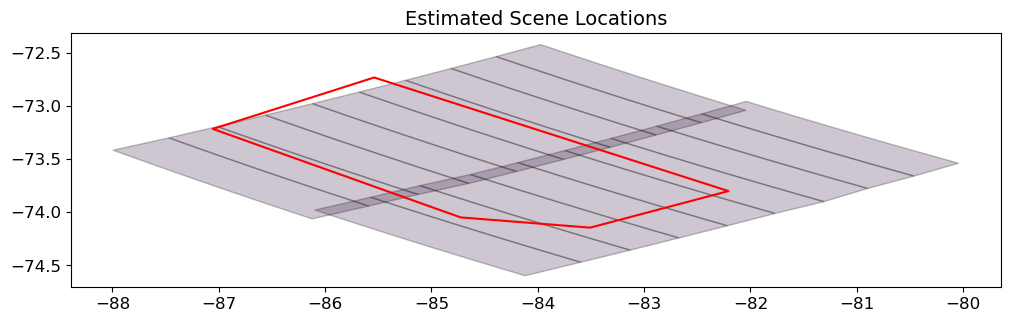

In [59]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

## Reframe Scenes (Optional)

Stitch sequential scenes and crop the subswath to a smaller area for faster processing when the full area is not needed.

In [60]:
sbas.compute_reframe(AOI)

Reframing:   0%|          | 0/4 [00:00<?, ?it/s]

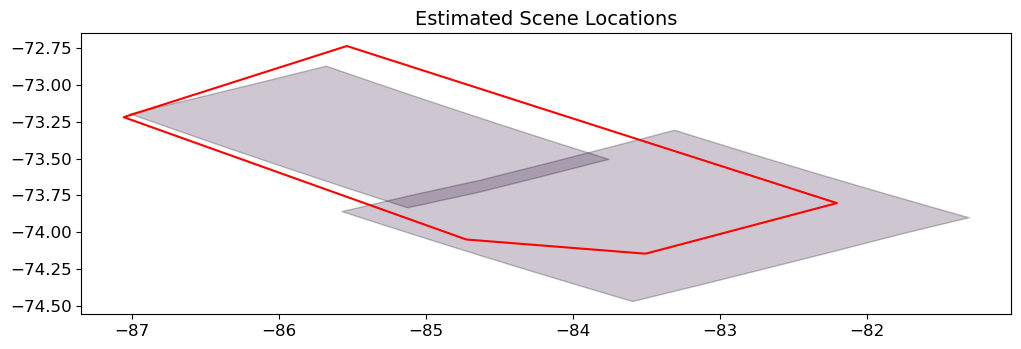

In [61]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

### Download SRTM DEM

The function below downloads SRTM1 or SRTM3 DEM and converts heights to ellipsoidal model using EGM96 grid.
Besides, for faster processing we can use pre-defined DEM file as explained above.

SRTM1 product is 30m resolution DEM and SRTM3 is 90m. SRTM1 is much bigger (~10 times) and is usable for small areas. Mainly 90m SRTM3 is the right choice. Use parameter resolution_meters (60 meters by default) to interpolate the DEM to required resolution for the future processing and output.

The DEM grid is NetCDF file.

In [62]:
sbas.download_dem(AOI)

DEM Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

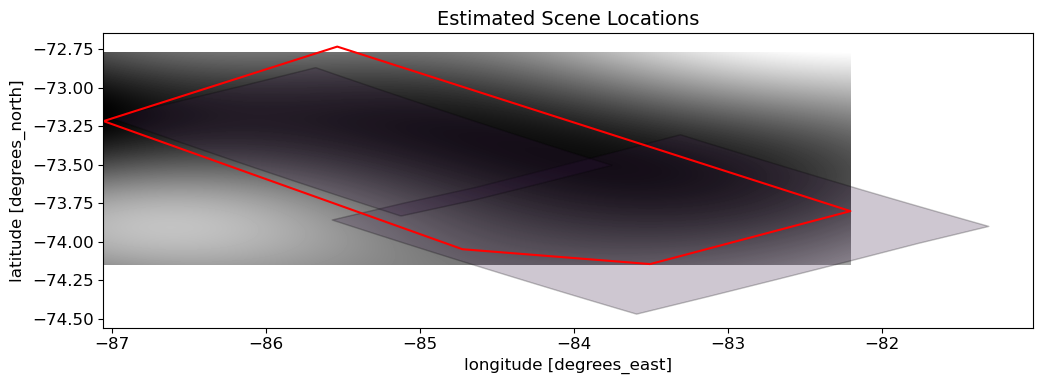

In [63]:
sbas.plot_scenes(AOI=AOI, aspect='equal')

## Download Landmask

In [64]:
sbas.download_landmask()

Landmask Downloading:   0%|          | 0/1 [00:00<?, ?it/s]

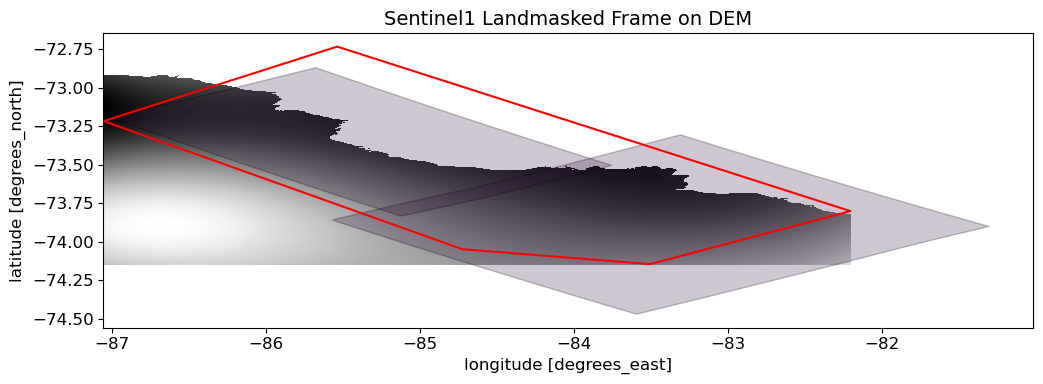

In [65]:
sbas.plot_scenes(AOI=AOI, dem=sbas.get_dem().where(sbas.get_landmask()), caption='Sentinel1 Landmasked Frame on DEM', aspect='equal')
plt.savefig('Sentinel1 Landmasked Frame on DEM.jpg')

## Align Images

In [66]:
if os.path.exists('/.dockerenv') and not 'google.colab' in sys.modules:
    # use special joblib backend in Docker containers
    sbas.compute_align(joblib_aligning_backend='threading')
else:
    sbas.compute_align()

Aligning Reference:   0%|          | 0/2 [00:00<?, ?it/s]

Aligning Repeat:   0%|          | 0/2 [00:00<?, ?it/s]

Merging Subswaths:   0%|          | 0/2 [00:00<?, ?it/s]

## Geocoding Transform

In [67]:
sbas.compute_geocode(45.)

Radar Transform Computing:   0%|          | 0/4 [00:00<?, ?it/s]

Radar Transform Saving:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Radar Transform Indexing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

/opt/conda/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/opt/conda/lib/python3.11/site-packages/dask/array/reductions.py:654: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)


Radar Inverse Transform Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

Satellite Look Vector Computing:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

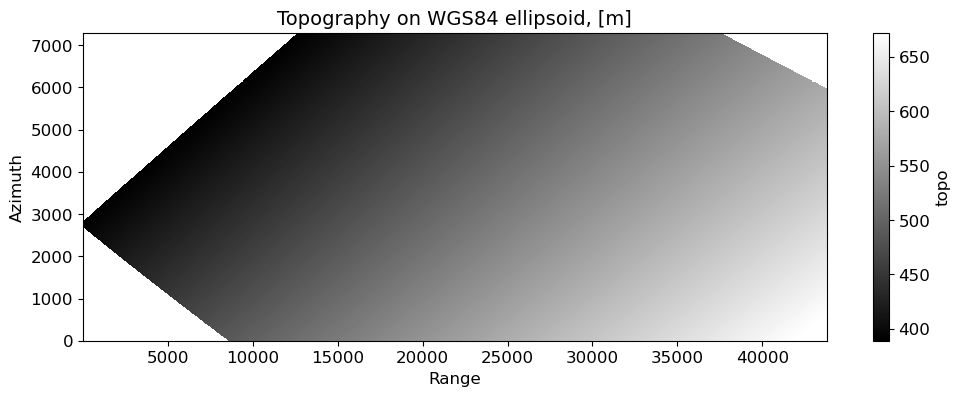

In [68]:
sbas.plot_topo()
plt.savefig('Topography in Radar Coordinates.jpg')

## Interferogram

The code below is detailed for education reasons and can be more compact excluding optional arguments. See other PyGMTSAR examples for shorter version.

In [69]:
# for a pair of scenes only two interferograms can be produced
# this one is selected for scenes sorted by the date in direct order
pairs = [sbas.to_dataframe().index]
pairs

[Index(['2021-03-08', '2021-03-20'], dtype='object', name='date')]

In [ ]:
# load radar topography
topo = sbas.get_topo()
# load Sentinel-1 data
data = sbas.open_data()
# Gaussian filtering 90m cut-off wavelength with multilooking 3x12 on Sentinel-1 intensity
intensity = sbas.multilooking(np.square(np.abs(data)), wavelength=90, coarsen=(3,12))
# calculate phase difference with topography correction
phase = sbas.phasediff(pairs, data, topo)
# Gaussian filtering 90m cut-off wavelength with multilooking
phase = sbas.multilooking(phase, wavelength=90, coarsen=(3,12))
# correlation on 3x12 multilooking data
corr = sbas.correlation(phase, intensity)
# Goldstein filter in 32 pixel patch size on square grid cells produced using 1:4 range multilooking
phase_goldstein = sbas.goldstein(phase, corr, 16)
# convert complex phase difference to interferogram
intf = sbas.interferogram(phase_goldstein)
# materialize for a single interferogram
tqdm_dask(result := dask.persist(intf[0], corr[0]), desc='Compute Phase and Correlation')
# unpack results
intf, corr = result

Compute Phase and Correlation:   0%|          | 0/9000000.0 [00:00<?, ?it/s]

In [ ]:
# geocode
intf_ll = sbas.ra2ll(intf)
corr_ll = sbas.ra2ll(corr)
dem = sbas.get_dem().interp_like(intf_ll).where(np.isfinite(intf_ll))
landmask_ll = sbas.get_landmask().interp_like(intf_ll)

In [ ]:
sbas.plot_landmask(landmask_ll, aspect='equal')

In [ ]:
sbas.plot_interferogram(intf_ll.where(landmask_ll), aspect='equal')
plt.savefig('Phase, [rad].jpg')

In [ ]:
sbas.plot_topo(dem.where(landmask_ll), aspect='equal')

In [ ]:
sbas.plot_correlation(corr_ll.where(landmask_ll), aspect='equal')
plt.savefig('Correlation.jpg')

In [ ]:
# plot all of the frame
sbas.plot_correlation(corr_ll, aspect='equal')
plt.savefig('Correlation.jpg')

In [ ]:
# prepare topography and phase
ds = xr.merge([dem.where(landmask_ll).rename('z'), intf_ll.where(landmask_ll)]).rename({'lat': 'y', 'lon': 'x'})
# crop grid
ds = ds.isel(y=slice(40,-50),x=slice(90,-40))
# decimate large grid
#ds = ds.sel(y=ds.y[::2], x=ds.x[::2])
# convert to VTK structure
vtk_grid = pv.StructuredGrid(NCubeVTK.ImageOnTopography(ds))
vtk_grid.save('intf.vtk')
vtk_grid

In [ ]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('intf.vtk').scale([1, 1, 0.00002], inplace=True), scalars='phase', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Interferogram.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Interferogram on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Unwrapping

Unwrapping process requires a lot of RAM and that's really RAM consuming when a lot of parallel proccesses running togeter. To limit the parallel processing tasks apply argument "n_jobs". The default value n_jobs=-1 means all the processor cores van be used. Also, use interferogram decimation above to produce smaller interferograms. And in addition a custom SNAPHU configuration can reduce RAM usage as explained below.

Attention: in case of crash on MacOS Apple Silicon run Jupyter as

`OBJC_DISABLE_INITIALIZE_FORK_SAFETY=YES no_proxy='*' jupyter notebook`

In [ ]:
# mask low-coherence areas using threshold value 0.1
tqdm_dask(unwrap := sbas.unwrap_snaphu(intf.where(corr>=0.1), corr).persist(),
          desc='SNAPHU Unwrapping')

In [ ]:
# geocode to geographic coordinates and crop empty borders
unwrap_ll = sbas.ra2ll(unwrap.phase)

In [ ]:
sbas.plot_phase(unwrap_ll.where(landmask_ll), caption='Unwrapped Phase\nGeographic Coordinates, [rad]', quantile=[0.02, 0.99], aspect='equal')
plt.savefig('Unwrapped Phase Geographic Coordinates, [rad].jpg')

In [ ]:
# prepare topography and phase
ds = xr.merge([dem.where(landmask_ll).rename('z'), unwrap_ll.where(landmask_ll)]).rename({'lat': 'y', 'lon': 'x'})
# crop grid
ds = ds.isel(y=slice(40,-50),x=slice(90,-40))
# decimate large grid
#ds = ds.sel(y=ds.y[::2], x=ds.x[::2])
# convert to VTK structure
vtk_grid = pv.StructuredGrid(NCubeVTK.ImageOnTopography(ds))
vtk_grid.save('unwrap.vtk')
vtk_grid

In [ ]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('unwrap.vtk').scale([1, 1, 0.00002], inplace=True), scalars='phase', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D Unwrapped Interferogram.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive Unwrapped Interferogram on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## LOS Displacement

In [ ]:
# geocode to geographic coordinates and crop empty borders
los_disp_mm_ll = sbas.los_displacement_mm(unwrap_ll)

In [ ]:
sbas.plot_displacement(los_disp_mm_ll.where(landmask_ll), caption='LOS Displacement\nGeographic Coordinates, [mm]', quantile=[0.01, 0.99], aspect='equal')
plt.savefig('LOS Displacement Geographic Coordinates, [mm].jpg')

In [ ]:
# prepare topography and phase
ds = xr.merge([dem.where(landmask_ll).rename('z'), los_disp_mm_ll.where(landmask_ll)]).rename({'lat': 'y', 'lon': 'x'})
# decimate large grid
#ds = ds.sel(y=ds.y[::2], x=ds.x[::2])
# convert to VTK structure
vtk_grid = pv.StructuredGrid(NCubeVTK.ImageOnTopography(ds))
vtk_grid.save('los.vtk')
vtk_grid

In [ ]:
# build interactive 3D plot
plotter = pv.Plotter(notebook=True)
plotter.add_mesh(pv.read('los.vtk').scale([1, 1, 0.00002], inplace=True), scalars='los', cmap='turbo', ambient=0.1, show_scalar_bar=True)
plotter.show_axes()
plotter.show(screenshot='3D LOS Displacement.png', jupyter_backend='panel', return_viewer=True)
plotter.add_title(f'Interactive LOS Displacement on DEM', font_size=32)
plotter._on_first_render_request()
panel.panel(
    plotter.render_window, orientation_widget=plotter.renderer.axes_enabled,
    enable_keybindings=False, sizing_mode='stretch_width', min_height=600
)

## Conclusion

For now you have the full control on interferometry processing and unwrapping and able to run it everywhere: on free of charge Google Colab instances, on local MacOS and Linux computers and on Amazon EC2 and Google Cloud VM and AI Notebook instances.